# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from scipy.optimize import curve_fit

# **INTRODUCTION**

In [2]:
#introduction

In [3]:
#ising

In [4]:
#metropolis 

In [5]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

In [6]:
#Create a nxn lattice with random spin configuration
@jit(nopython=True)
def init_lattice(N):
    '''
    Return a random spin configuration in a 2d square lattice
    '''
    return np.random.choice(np.array([-1,1]),size=(N,N))

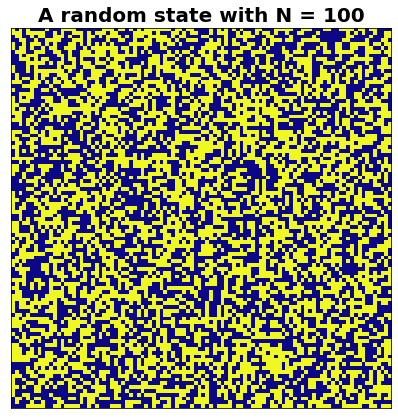

In [7]:
try_state = init_lattice(100)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(try_state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 20, fontweight = "bold" )
plt.show()

In [8]:
#Let's define some useful functions
@jit(nopython=True)
def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy +=  -state[i,j] * nn
    return energy / 2
    
@jit(nopython=True)    
def magnetization(state):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn

@jit(nopython=True)
def delta(s,a,b):
    L= int(s.shape[0])
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a,b]*(s[a,(b+1)%L]+s[a,(b-1)%L]+s[(a+1)%L,b]+s[(a-1)%L,b])   #consider only nearest neighbours


# **PHASE TRANSITION ANALYSIS**

In [9]:
# Define Monte Carlo function
@jit(nopython=True)
def mc_step(s,temp):
    
    L = int(s.shape[0])
    for i in prange(int(L*L)):
        
        # choose a random spin on the grid
        a, b = np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E = delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[a,b]*=-1
    return s

## --- Code taken from github (slightly modified for what we need)---

In [10]:
@jit(nopython=True)
def Ising(L,T,eq_steps,steps):
    
    s = np.ones((L,L))
    '''Equilibration'''
    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
    for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(s)
            M_eq[i] = magnetization(s)
            #update the state
            s = mc_step(s,T)
            
    '''Simulation'''
    E = np.zeros(steps)
    M = np.zeros(steps)
    for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(s)
            M[i] = magnetization(s)
            #update the state
            s = mc_step(s,T)

    
    E_mean = np.mean(E)
    M_mean = np.mean(M)
    C = (np.std(E)**2)/(T**2)
    Chi = (np.std(M)**2)/(T)
    E_var, M_var = np.std(E), np.std(M)

  ### Return results
    return (E_mean, M_mean, C, Chi,
            E_var, M_var,
            E_eq, M_eq, E, M) 



nt = 50
Te = np.linspace(0.5, 3.75, endpoint=True, num=nt)

L_val = [10,20,30,40,50]
nl = len(L_val)
eq_steps = int(1e2)
steps = int(1e4)

E_s = np.zeros((nl, nt))
M_s = np.zeros((nl, nt))
C_s = np.zeros((nl, nt))
Chi_s = np.zeros((nl, nt))


for i,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for j,T in enumerate(Te):
    #print('\t{}/{}  beta: {}'.format(j,N_T,beta))
        E_mean, M_mean, C_mean, Chi_mean, E_var, M_var, E_eq, M_eq, E, M = Ising( L, T, eq_steps=eq_steps, steps=steps)

        E_s[i,j] = E_mean
        M_s[i,j] = M_mean
        C_s[i,j] = C_mean
        Chi_s[i,j] = Chi_mean
    

Simulating N=10
Simulating N=20
Simulating N=30
Simulating N=40
Simulating N=50


In [11]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy','Magnetisation','Specific Heat','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (16,10))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(nl):
            ax.plot(Te[1:], physical_quantities[i][j][1:] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)


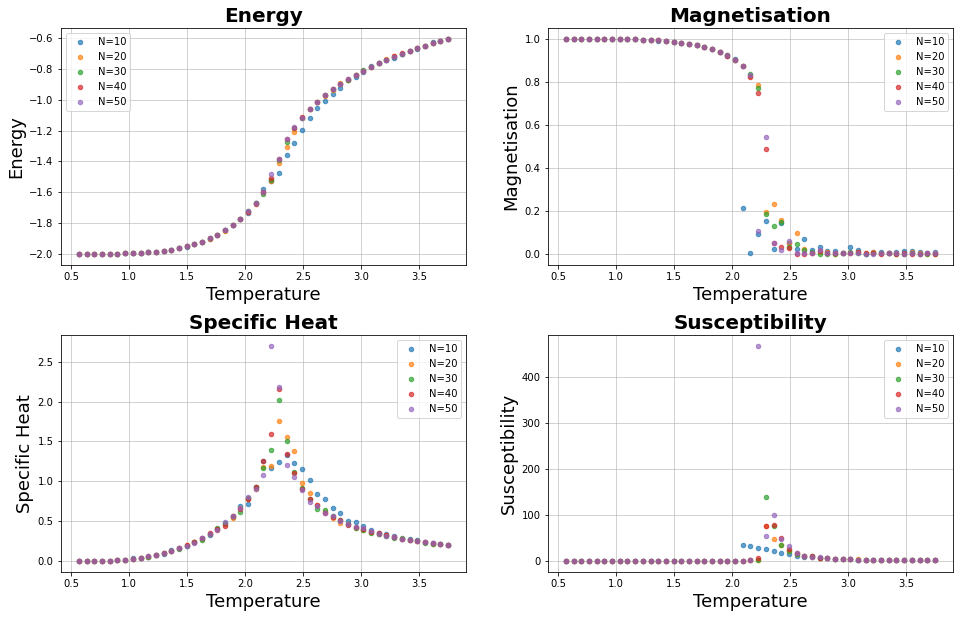

In [12]:
plot_values(E_s,M_s,C_s,Chi_s,L_val)

*This next part is the finite-size scaling, it doesn't make sense with 5 points but I did it only to check if I had similar results with this method and our method *

[ 8.15980062 10.31565842 11.73987462 11.74217431 13.97120915]
gamma: 3.256035511458541


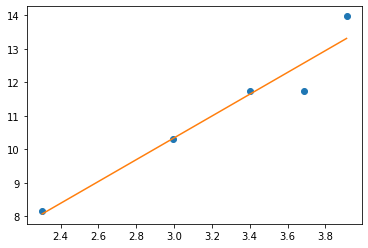

In [13]:
from scipy import stats

T_c = 2/np.log(1 + np.sqrt(2))  #known value from onsager


Chi_max = np.zeros((nl))
for i in range(nl):
    Tmax = np.argmax(Chi_s[i,:])             #Take the max of Chi for each dimension (it should be around Tc)
    Chi_max[i] = Chi_s[i,Tmax]
print(np.log(Chi_max))

logchi = np.log(Chi_max)
logl = np.log(L_val)
    
slope, intercept, _,_,_= stats.linregress(logl,logchi)
print('gamma:',slope)  

plt.plot(logl,logchi,'o')
plt.plot(logl,slope*logl+intercept)   

## ---Old code updated---

In [14]:
@jit(nopython=True)
def old_Ising(L,T,time_f,realiz):
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((L,L))
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
            
        E = np.mean(energies)
        M = np.mean(magnetizations)                
        C = (np.std(energies)**2)/(T**2)
        Chi = (np.std(magnetizations)**2)/(T)
    
    return (E,M,C,Chi)
    
L_val=[10,20,30,40,50]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 5    
nt = 50 
E_old,M_old,C_old,Chi_old = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(.5,3.75,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = old_Ising(L,T,time_f,realiz)
        E_old[il,it] = E
        M_old[il,it] = M
        C_old[il,it] = C
        Chi_old[il,it] = Chi

Simulating N=10
Simulating N=20
Simulating N=30
Simulating N=40
Simulating N=50


In [15]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy','Magnetisation','Specific Heat','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (16,10))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(nl):
            ax.plot(Te, physical_quantities[i][j] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

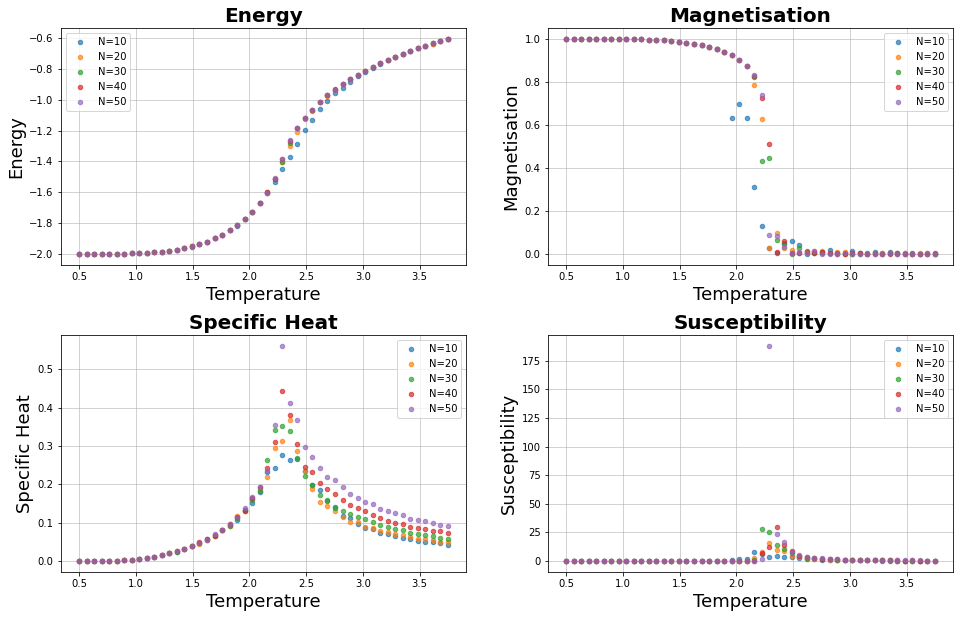

In [16]:
plot_values(E_old,M_old,C_old,Chi_old,L_val)

* Finite size scaling just to confront the results with the ones obrained before *

[ 6.67892808  8.77477185 10.14588267 10.77063798 13.05917544]
gamma: 3.620725049201659


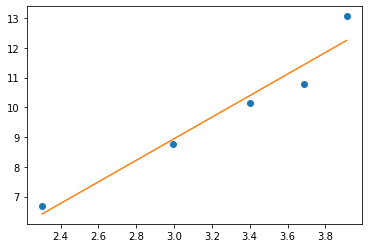

In [17]:
from scipy import stats

T_c = 2/np.log(1 + np.sqrt(2))  #known value from onsager


Chi_max = np.zeros((nl))
for i in range(nl):
    Tmax = np.argmax(Chi_old[i,:])             #Take the max of Chi for each dimension (it should be around Tc)
    Chi_max[i] = Chi_old[i,Tmax]
print(np.log(Chi_max))

logchi = np.log(Chi_max)
logl = np.log(L_val)
    
slope, intercept, _,_,_= stats.linregress(logl,logchi)
print('gamma:',slope)  

plt.plot(logl,logchi,'o')
plt.plot(logl,slope*logl+intercept)   

Nice!

From this point on, everything is identical to the old notebook and has to be adapted to the new code.

<hr style="border: 1px solid black;">



# **Critical exponent estimation**

## Exponent $\gamma$

In the termodinamic limit $N\rightarrow \infty$, we know that $\chi \sim |T-T_c|^{-\gamma}$. We try to estimate $\gamma$ as N increases. The expected value for 2D Ising is $\gamma=7/4 \sim 1.75$

1st try: fitting only the right part of the plot.
by doing so:
- The fit is good and it fits the points well
- But the values for Tc and gamma are a wrong (even if Tc is sometimes reasonable)

In [ ]:
from scipy import optimize

T_c = 2.26     #known value from Onsager

L_values = np.array([10,25,50])
Te = np.linspace(1.,7.,nt)

def powerlaw(T, k=1, gamma=1.3, Tc=T_c):
    return k*(np.abs(T-Tc))**(-gamma)



ks, gammas, Tcs, = np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],)),np.zeros((L_values.shape[0],))
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1,figsize = (10,20))

for i in range(L_values.shape[0]):
    Tmax = np.argmax(Chi_L[i]) #we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], Chi_L[i][Tmax:]/(L_values[i]**2), maxfev=int(1e6))
    ks[i] = params[0]
    gammas[i] = params[1]
    Tcs[i] = params[2]
print(Tmax)

ax1.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[0], gammas[0], Tcs[0]),'orange', label='fit')
ax1.plot(Te[Tmax:], Chi_L[0][Tmax:]/(L_values[0]**2), 'o',color="navy", label='N={}'.format(L_values[0]))
ax1.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[0]),'%.3f'%Tcs[0]), transform=ax1.transAxes)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Susceptibility')
ax1.legend()

ax2.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[1], gammas[1], Tcs[1]),'orange', label='fit')
ax2.plot(Te[Tmax:], Chi_L[1][Tmax:]/(L_values[1]**2), 'o',color="red", label='N={}'.format(L_values[1]))
ax2.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[1]),'%.3f'%Tcs[1]), transform=ax2.transAxes)
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Susceptibility')
ax2.legend()

ax3.plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[2], gammas[2], Tcs[2]),'orange', label='fit')
ax3.plot(Te[Tmax:], Chi_L[2][Tmax:]/(L_values[2]**2), 'o',color="green", label='N={}'.format(L_values[2]))
ax3.text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(-1*gammas[2]),'%.3f'%Tcs[2]), transform=ax3.transAxes)
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Susceptibility')
ax3.legend()

    

## A try with the working Gloria code

2nd try: as Gloria did for the magnetization, I slightly changed the function to fit.
I used the same library that Gloria used for beta in the beginning, but after a few tries I noticed that there were no big differences so I surrendered again to use curve_fit.

In this case, with the library that Gloria used, I tried first to fit only the right part of the plot, and obtained the same results as before. I tried then to fit the whole plot (both with the other library and with curve_fit, I got the same results) and this happens:
- If i slighly change the initial guess, the fit is completely off and the results are too;
- The better initial guess to have a fit that somehow resembles the data is to have Tc=2.7 and gamma=-1.2.
  the results, however, are possibly the worst thing to happen to humankind.
  The fit is shifted and, again, gamma is too small.

In [ ]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt

L_values = np.array([10,25,50])

T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
Te = np.linspace(1.,7.,nt)

for i in range(L_values.shape[0]):

    Tmax = np.argmax(Chi_L[i])
    Ts2fit = Te[Tmax:]
    Chi2fit = Chi_L[i][Tmax:]
    print(Chi2fit.shape)
    print(Ts2fit.shape)

    # Function to fit to
    def Chi_fit(Ts, Tcinf, gamma, a):
        Chi = a * np.abs((-Ts + Tcinf)/ Tcinf ) ** (gamma)
        return Chi

    # Initial guess
    guess = [2.7, -1.2, 1]

    pars, pint = optimize.curve_fit(Chi_fit, Te, Chi_L[i], guess, maxfev=int(1e6), method='trf')
    Tcinf, gamma, a = pint
    Tcinf = pars[0]
    gamma = pars[1]
    a = pars[2]

    print ('T_{{c}} = {0:1.3f} (95% confidence interval = {1:1.3f} {2:1.3f}])\n'.format(pars[0], pint[0][0], pint[0][1]))
    print ('gamma = {0:1.3f} (95% confidence interval = [{1:1.3f} {2:1.3f}])'.format(pars[1], pint[1][0], pint[1][1]))

    # Plotting
    Tfit = np.linspace(Ts2fit.min(), T_c)
    plt.plot(Te, Chi_L[i], 'o', label='N=' + str(L_values[i]))
    plt.plot(Te, Chi_fit(Te, Tcinf, gamma, a))
    plt.xlabel('Temperature (K)', fontsize=16)
    plt.ylabel('Susceptibility', fontsize=16)
    plt.legend()
    plt.show()

## a consideration on these results:

To understand better why the fit wasn't working, below I plotted the function as it should be in the thermodynamic limit.    
What I noticed is that the function is much more peaked that our plots are, and I think this has all to do with the dimension of the lattice, which is too small.   

In [ ]:
 def Chi_fit(Ts, Tcinf, gamma, a):
        Chi = a * np.abs((-Ts + Tcinf) / Tcinf) ** gamma
        return Chi
    
chi = Chi_fit(Te,2.27,-1.75,1)                             #Plotting the function with its expected values for Tc and
                                                           #gamma, to see if the function is correct.
                                                           #it seems to have the same behaviour as our data, so I
                                                           #think the only reason the fit is not good is because
                                                           #our system is too small
plt.plot(Te,chi)

# *Trying the finite-size scaling for gamma*

Since the size of our system is finite, we expect it to not give us the best values for gamma and Tc. With the finite-size scaling analysis, we take into consideration the dimension of the system, and we know that, as $\chi$ gets closer to the critical temperature, it scales as : $\chi \sim L^{\gamma/\nu}$ where the parameters to be estimated are $\gamma$ and $\nu$ ($\gamma$ should be around $7/4$ while, for 2D Ising, $\nu$ should be $1$.)

In order to do this, many different dimensions are needed, since we need to fit the maximum values we find for $\chi$ (which should be around the critical temperature), and the dimension of the lattice.
Three points are, of course, too few, but anyway I wrote the code just to try it out.\\    
If we do a linear regression between $log(\chi)$ and $log(L)$ we should find as the slope $\gamma/\nu$.

In [ ]:
from scipy import stats
L_values = np.array([10,25,50])

Te = np.linspace(1.,7.,nt)
T_c = 2/np.log(1 + np.sqrt(2))  #known value from onsager


Chi_max = np.zeros((L_values.shape[0]))
for i in range(L_values.shape[0]):
    Tmax = np.argmax(Chi_L[i])             #Take the max of Chi for each dimension (it should be around Tc)
    Chi_max[i] = Chi_L[i][Tmax]
print(np.log(Chi_max))

logchi = np.log(Chi_max)
logl = np.log(L_values)
    
slope, intercept, _,_,_= stats.linregress(logl,logchi)
print('gamma:',slope)  #(of course not right)

plt.plot(logl,logchi,'o')
plt.plot(logl,slope*logl+intercept)    
    

## Exponent $\beta$

In the termodinamic limit $N\rightarrow \infty$, we know that $M \sim |T-T_c|^{-\beta}$. We try to estimate $\beta$ as N increases. The expected value for 2D Ising is $\beta=1/8 \sim 0.125$.

# *WORKING CODE FOR BETA*

In [ ]:
plt.plot(Te[:20],M_L[1][:20],'o-')  #per vedere quanti punti prendere

In [ ]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from pycse import nlinfit # ---> pip install pycse

T_c = 2/np.log(1 + np.sqrt(2))  #known value from Onsager
Te = np.linspace(1.,7.,nt)
L_values = np.array([10,25,50])

for i in range(L_values.shape[0]):

    # Let us fit the first 45 values on the left of Onsager's Tc
    Ts2fit = Te[0:20]
    M2fit = M_L[i][:20]

    # Function to fit to
    def M_fit(Ts, Tcinf, beta, a):
        M = a * np.abs((-Ts + Tcinf) / Tcinf) ** beta
        return M

    # Initial guess
    guess = [2.4, 0.1, 1]

    pars, pint, SE = nlinfit(M_fit, Ts2fit, M2fit, guess, alpha=0.05)
    Tcinf, beta, a = pint
    Tcinf=pars[0]
    beta=pars[1]
    a=pars[2]

    print ('T_{{c}} = {0:1.3f} (95% confidence interval = {1:1.3f} {2:1.3f}])\n'.format(pars[0], pint[0][0], pint[0][1]))
    print ('beta = {0:1.3f} (95% confidence interval = [{1:1.3f} {2:1.3f}])'.format(pars[1], pint[1][0], pint[1][1]))

    # Plotting
    Tfit = np.linspace(Ts2fit.min(), T_c)
    plt.plot(Te, M_L[i], 'o', label='N=' + str(L_values[i]))
    plt.plot(Ts2fit, M_fit(Ts2fit, Tcinf, beta, a))
    plt.xlabel('Temperature (K)', fontsize=16)
    plt.ylabel('Magnetization', fontsize=16)
    plt.legend()
    plt.show()